In [28]:
!pip install torch_geometric

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
import torch
from torch_geometric.nn import GCNConv, GAE, VGAE, LayerNorm
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import tracemalloc
import time
from utils import *
from metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to measure GPU memory usage
def get_gpu_memory():
    return torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MB


# Main function to execute the steps
def get_fmnist_graph():
    dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
    data = dataset[0]
    data.num_classes = dataset.num_classes
    data.num_node_features = dataset.num_node_features


    # Print the Data object to verify
    print(data)



    return data

In [2]:
data = get_fmnist_graph()

X = data.x.numpy()

# local_metrics = LocalMetric()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7, num_node_features=1433)


In [51]:
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class ResidualVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x
        x = F.relu(self.conv1(x, edge_index))
        mu = self.conv2_mu(x, edge_index)
        logstd = self.conv2_logstd(x, edge_index)

        if identity.size(-1) != mu.size(-1):
            identity = self.shortcut(identity)

        mu += identity
        logstd += identity

        return mu, logstd


class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels_AE = 2
num_features = data.num_features
num_classes = data.num_classes
epochs_AE = 400
hidden_channels_AE = 16

# Model initialization
model = VGAE(ResidualVGAEEncoder(num_features, out_channels_AE)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

GAE_loss_history = []

# Training the GAE model with metrics measurement
print("Training GAE model...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

for epoch in range(1, epochs_AE + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    GAE_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"GAE Training Time: {time_taken:.2f} seconds")
print(f"GAE Training RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"GAE Training GPU Memory usage: {gpu_used:.2f}MB")


# Update data.x with the encoded features for classification
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()
data.x = encoded_features
hidden_channels_GNN = 16

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels_AE, hidden_channels_GNN, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

GNN_loss_history = []

# Training the GNN model
for epoch in range(400):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    GNN_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Training GAE model...
Epoch: 10, Loss: 1.4995591640472412
Epoch: 20, Loss: 1.4173259735107422
Epoch: 30, Loss: 1.376150369644165
Epoch: 40, Loss: 1.3514182567596436
Epoch: 50, Loss: 1.3329739570617676
Epoch: 60, Loss: 1.3195762634277344
Epoch: 70, Loss: 1.3064074516296387
Epoch: 80, Loss: 1.2949782609939575
Epoch: 90, Loss: 1.2867627143859863
Epoch: 100, Loss: 1.268365502357483
Epoch: 110, Loss: 1.248374104499817
Epoch: 120, Loss: 1.2288833856582642
Epoch: 130, Loss: 1.2101681232452393
Epoch: 140, Loss: 1.1886868476867676
Epoch: 150, Loss: 1.1667078733444214
Epoch: 160, Loss: 1.1635228395462036
Epoch: 170, Loss: 1.151511311531067
Epoch: 180, Loss: 1.1320725679397583
Epoch: 190, Loss: 1.115225076675415
Epoch: 200, Loss: 1.126007318496704
Epoch: 210, Loss: 1.112615704536438
Epoch: 220, Loss: 1.107749104499817
Epoch: 230, Loss: 1.0948352813720703
Epoch: 240, Loss: 1.0776318311691284
Epoch: 250, Loss: 1.0876688957214355
Epoch: 260, Loss: 1.067686915397644
Epoch: 270, Loss: 1.05924904346466

In [52]:
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    preds = out.argmax(dim=1)
    labels = data.y
    mask = data.test_mask
    test_preds = preds[mask].cpu().numpy()
    test_labels = labels[mask].cpu().numpy()

    accuracy = accuracy_score(test_labels, test_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print(f"GNN accuracy: {accuracy:.4f}, GNN precision: {precision:.4f}, GNN recall: {recall:.4f}, GNN F1 score: {f1:.4f}")

GNN accuracy: 0.5250, GNN precision: 0.4775, GNN recall: 0.5088, GNN F1 score: 0.4816


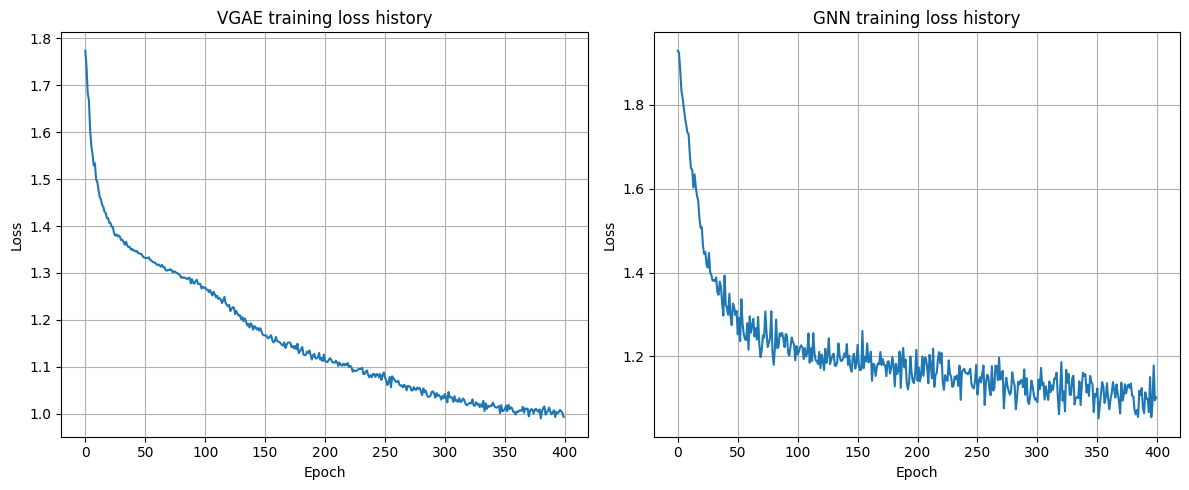

In [53]:
plt.figure(figsize=(12, 5))

# GAE training loss history
plt.subplot(1, 2, 1)
plt.plot(GAE_loss_history, label='GAE training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGAE training loss history')
plt.grid(True)  # Assuming you want to always display the grid


# GNN training loss history
plt.subplot(1, 2, 2)
plt.plot(GNN_loss_history, label='GNN training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GNN training loss history')
plt.grid(True)  # Assuming you want to always display the grid


plt.tight_layout()
plt.show()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7, num_node_features=1433)


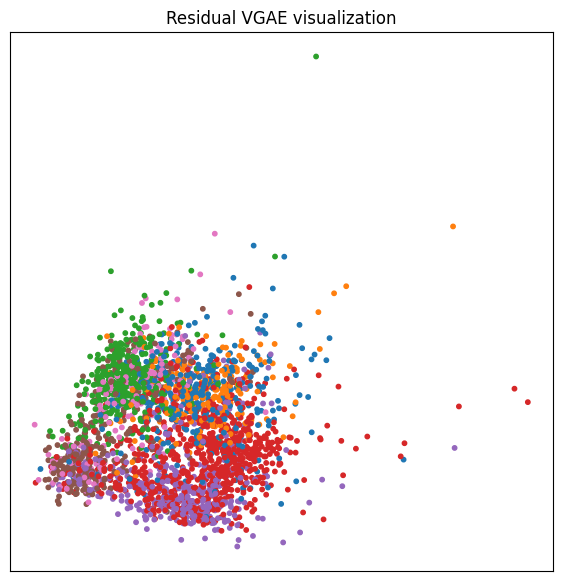

In [54]:
pure_data = get_fmnist_graph()
pure_X = pure_data.x.cpu().detach().numpy()
pure_labels = pure_data.y.cpu().numpy()

fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, encoded_features.cpu().detach().numpy(), pure_labels, 'Residual VGAE visualization', size=10, sample=False)
plt.show()

In [35]:
GAE_variant = "residual"
dataset_name = "Cora"
algorithm_name = "VGAE"
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features.cpu().detach().numpy(),
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

Calculating d_hd
Cora VGAE-residual


# 2. Residual GAE + tSNE

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7, num_node_features=1433)


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Training GAE model...
Epoch: 10, Loss: 2.9040169715881348
Epoch: 20, Loss: 2.616093397140503
Epoch: 30, Loss: 2.1730237007141113
Epoch: 40, Loss: 1.9251329898834229
Epoch: 50, Loss: 1.6875274181365967
Epoch: 60, Loss: 1.56007719039917
Epoch: 70, Loss: 1.4828381538391113
Epoch: 80, Loss: 1.4312347173690796
Epoch: 90, Loss: 1.4007275104522705
Epoch: 100, Loss: 1.3890767097473145
Epoch: 110, Loss: 1.370536208152771
Epoch: 120, Loss: 1.360522985458374
Epoch: 130, Loss: 1.3544888496398926
Epoch: 140, Loss: 1.3432695865631104
Epoch: 150, Loss: 1.3350279331207275
Epoch: 160, Loss: 1.335076928138733
Epoch: 170, Loss: 1.3230674266815186
Epoch: 180, Loss: 1.3221211433410645
Epoch: 190, Loss: 1.3177146911621094
Epoch: 200, Loss: 1.3157365322113037
Epoch: 210, Loss: 1.312915325164795
Epoch: 220, Loss: 1.3082380294799805
Epoch: 230, Loss: 1.305471658706665
Epoch: 240, Loss: 1.2995519638061523
Epoch: 250, Loss: 1.2964208126068115
Epoch: 260, Loss: 1.2882380485534668
Epoch: 270, Loss: 1.2864669561386

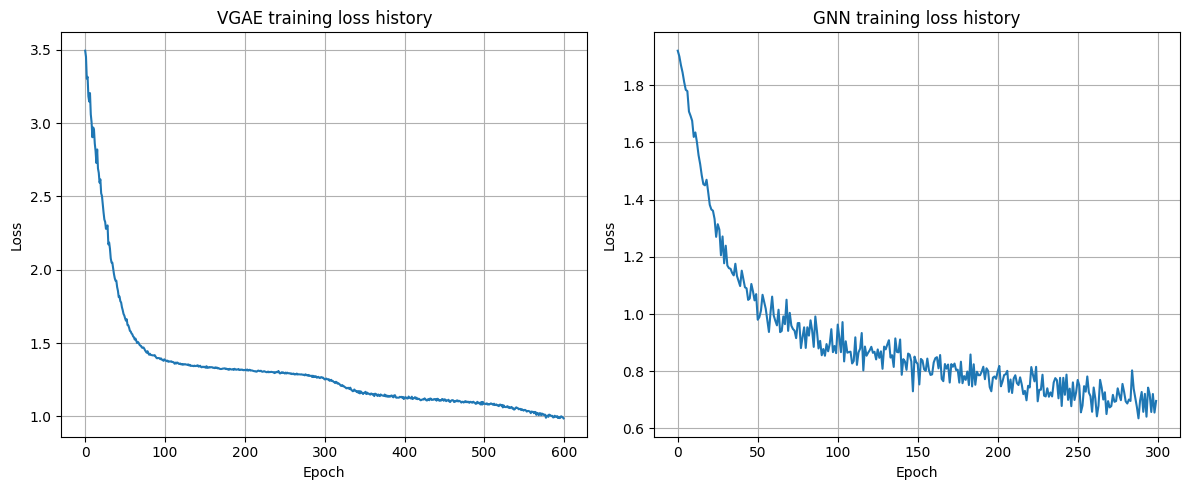

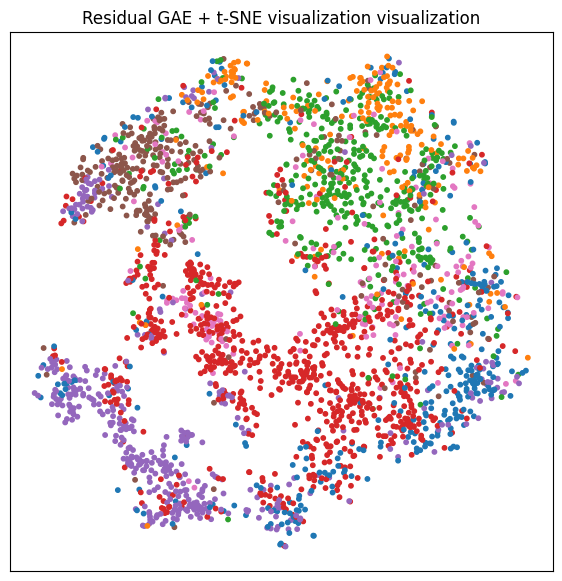

In [56]:
data = get_fmnist_graph()
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges

data = train_test_split_edges(data)

# Parameters
out_channels_AE = 16
num_features = data.num_features
num_classes = data.num_classes
epochs_AE = 600
hidden_channels_AE = 32

# Model initialization
model = VGAE(ResidualVGAEEncoder(num_features, out_channels_AE)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

GAE_loss_history = []

# Training the GAE model with metrics measurement
print("Training GAE model...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

for epoch in range(1, epochs_AE + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    GAE_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"GAE Training Time: {time_taken:.2f} seconds")
print(f"GAE Training RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"GAE Training GPU Memory usage: {gpu_used:.2f}MB")

# Update data.x with the encoded features for classification
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()
data.x = encoded_features
hidden_channels_GNN = 16

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels_AE, hidden_channels_GNN, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

GNN_loss_history = []

# Training the GNN model
for epoch in range(300):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    GNN_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    preds = out.argmax(dim=1)
    labels = data.y
    mask = data.test_mask
    test_preds = preds[mask].cpu().numpy()
    test_labels = labels[mask].cpu().numpy()

    accuracy = accuracy_score(test_labels, test_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print(f"GNN accuracy: {accuracy:.4f}, GNN precision: {precision:.4f}, GNN recall: {recall:.4f}, GNN F1 score: {f1:.4f}")

tsne = TSNE(n_components=2, random_state=0, metric='cosine')

# Perform t-SNE transformation with metrics measurement
print("Performing t-SNE transformation...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

tsne_results = tsne.fit_transform(encoded_features.cpu().detach().numpy())

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"t-SNE Transformation Time: {time_taken:.2f} seconds")
print(f"t-SNE Transformation RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"t-SNE Transformation GPU Memory usage: {gpu_used:.2f}MB")
plt.figure(figsize=(12, 5))

# GAE training loss history
plt.subplot(1, 2, 1)
plt.plot(GAE_loss_history, label='GAE training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGAE training loss history')
plt.grid(True)  # Assuming you want to always display the grid


# GNN training loss history
plt.subplot(1, 2, 2)
plt.plot(GNN_loss_history, label='GNN training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GNN training loss history')
plt.grid(True)  # Assuming you want to always display the grid


plt.tight_layout()
plt.show()

pure_labels = pure_data.y.cpu().numpy()


fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, tsne_results, pure_labels, 'Residual GAE + t-SNE visualization visualization', size=10, sample=False)
plt.show()



In [37]:
GAE_variant = "residual + t-SNE"
dataset_name = "Cora"
algorithm_name = "VGAE"
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

Calculating d_hd
Cora VGAE-residual + t-SNE


# 3. pure t-SNE

Performing t-SNE transformation...
t-SNE Transformation Time: 34.44 seconds
t-SNE Transformation RAM Memory usage: Current=0.04MB, Peak=23.88MB
t-SNE Transformation GPU Memory usage: 0.00MB
Calculating d_hd
Cora t-SNE


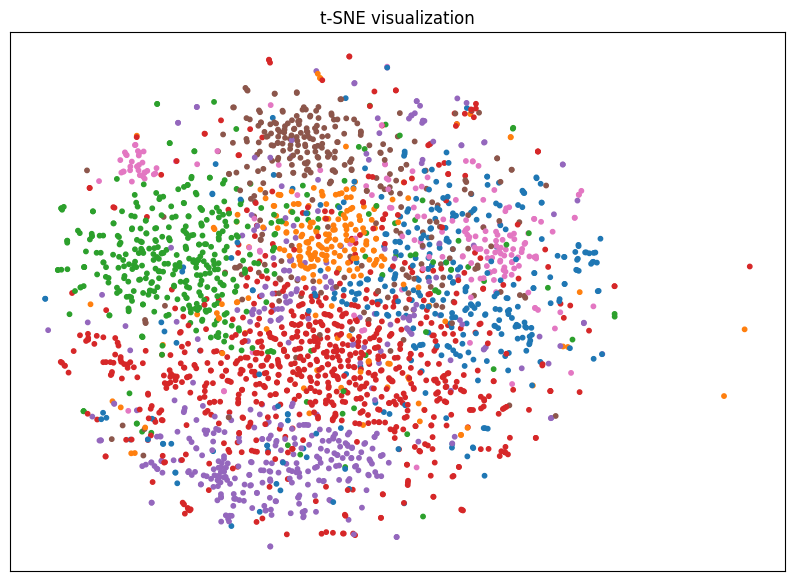

In [38]:
tsne = TSNE(n_components=2, random_state=0)
# Perform t-SNE transformation with metrics measurement
print("Performing t-SNE transformation...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

tsne_results = tsne.fit_transform(pure_X)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"t-SNE Transformation Time: {time_taken:.2f} seconds")
print(f"t-SNE Transformation RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"t-SNE Transformation GPU Memory usage: {gpu_used:.2f}MB")


GAE_variant = "t-SNE"
dataset_name = "Cora"
algorithm_name = ""
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}{GAE_variant}"))

visualise(tsne_results, pure_labels, 't-SNE visualization', size=10)


Finished.


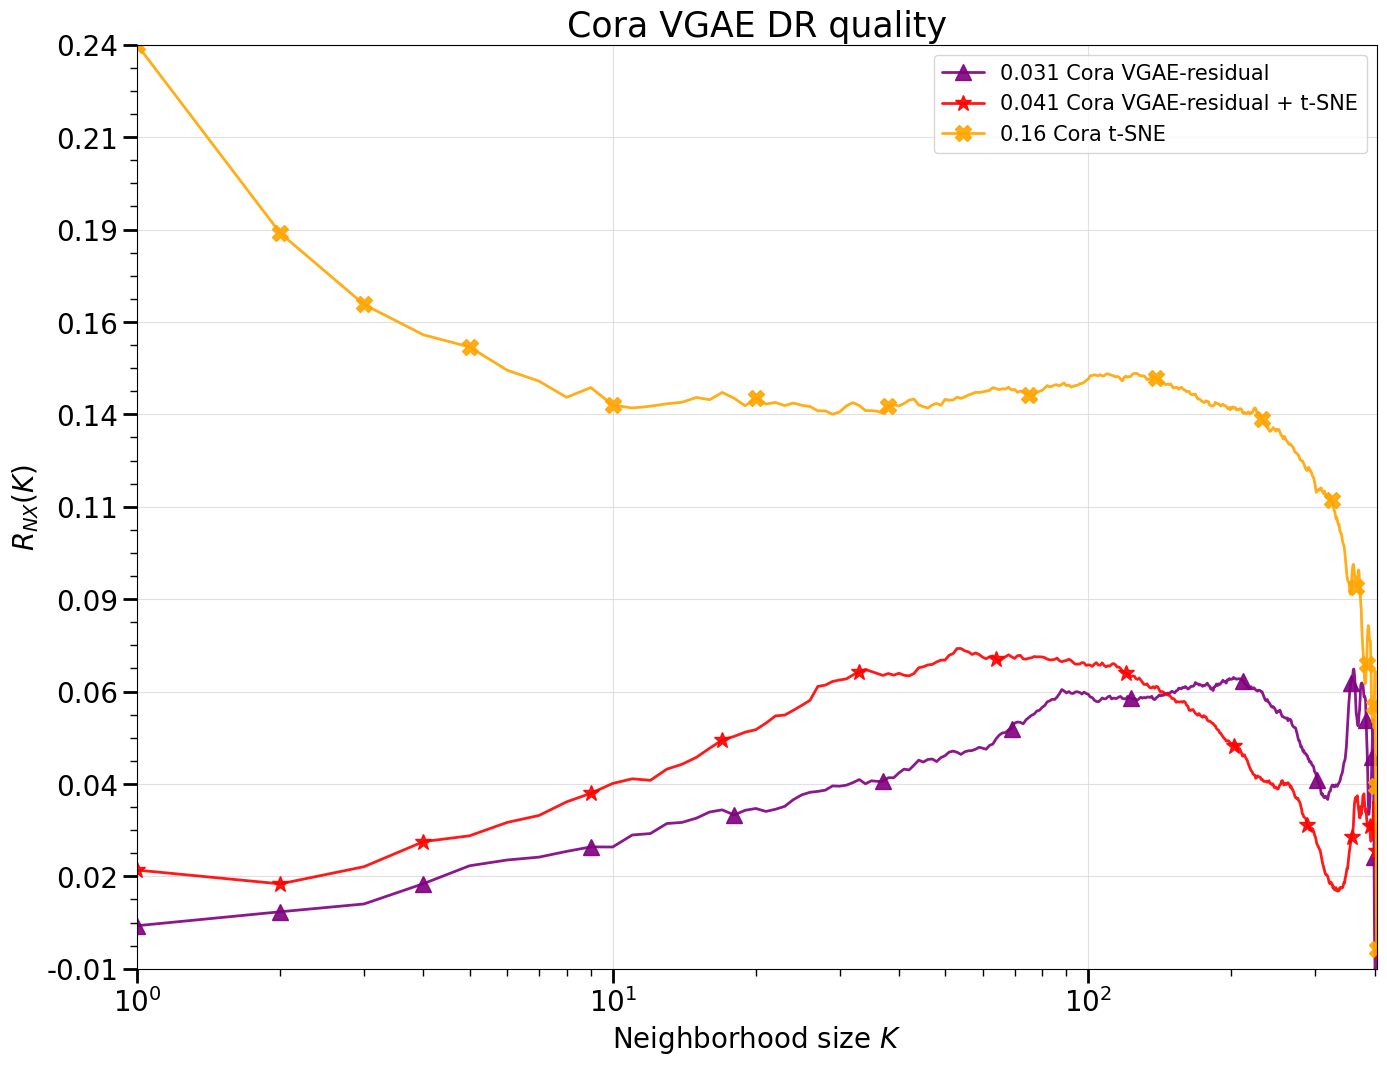

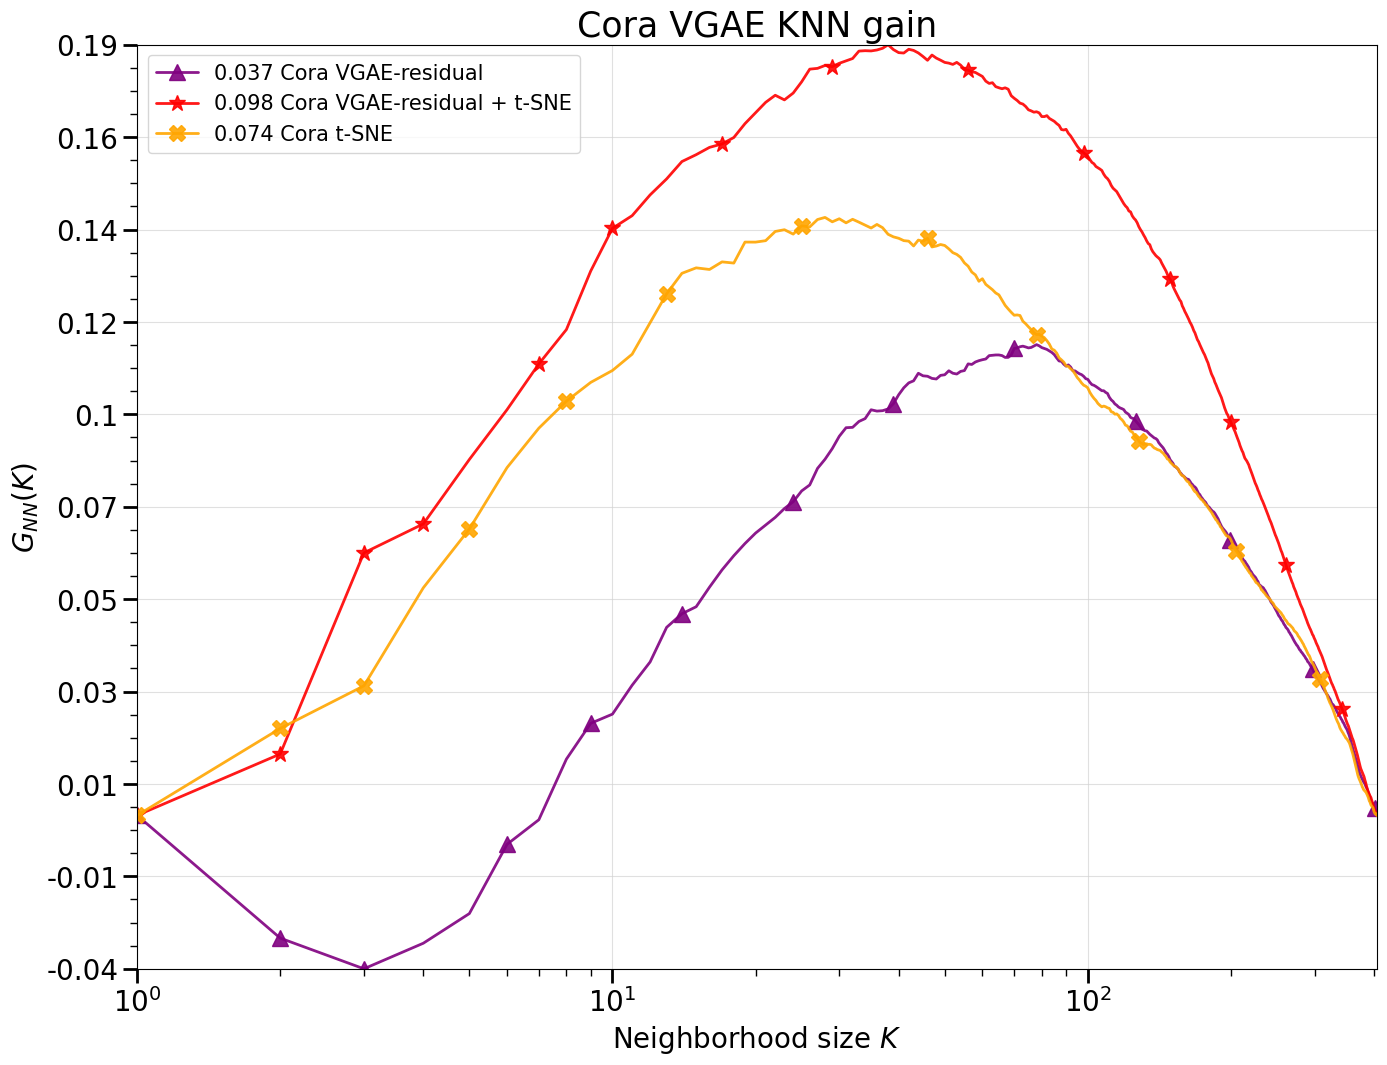

In [39]:
local_metrics.visualize(f"Cora VGAE")

# 4. Residual VGAE + UMAP & PaCMAP

In [3]:
class ResidualVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x
        x = F.relu(self.conv1(x, edge_index))
        mu = self.conv2_mu(x, edge_index)
        logstd = self.conv2_logstd(x, edge_index)

        if identity.size(-1) != mu.size(-1):
            identity = self.shortcut(identity)

        mu += identity
        logstd += identity

        return mu, logstd


data = get_fmnist_graph()
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges

data = train_test_split_edges(data)

# Parameters
out_channels_AE = 16
num_features = data.num_features
num_classes = data.num_classes
epochs_AE = 600
hidden_channels_AE = 32

# Model initialization
model = VGAE(ResidualVGAEEncoder(num_features, out_channels_AE)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

GAE_loss_history = []

# Training the GAE model with metrics measurement
print("Training GAE model...")


for epoch in range(1, epochs_AE + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    GAE_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')


# Update data.x with the encoded features for classification
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7, num_node_features=1433)


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Training GAE model...
Epoch: 10, Loss: 3.034297466278076
Epoch: 20, Loss: 2.485891342163086
Epoch: 30, Loss: 2.0971288681030273
Epoch: 40, Loss: 1.7727630138397217
Epoch: 50, Loss: 1.5973849296569824
Epoch: 60, Loss: 1.490736722946167
Epoch: 70, Loss: 1.4312283992767334
Epoch: 80, Loss: 1.3926405906677246
Epoch: 90, Loss: 1.3770203590393066
Epoch: 100, Loss: 1.3710625171661377
Epoch: 110, Loss: 1.3532092571258545
Epoch: 120, Loss: 1.3476853370666504
Epoch: 130, Loss: 1.337695598602295
Epoch: 140, Loss: 1.3349007368087769
Epoch: 150, Loss: 1.3316118717193604
Epoch: 160, Loss: 1.3185471296310425
Epoch: 170, Loss: 1.3127564191818237
Epoch: 180, Loss: 1.301743507385254
Epoch: 190, Loss: 1.2889254093170166
Epoch: 200, Loss: 1.2769792079925537
Epoch: 210, Loss: 1.2562206983566284
Epoch: 220, Loss: 1.2329273223876953
Epoch: 230, Loss: 1.1993391513824463
Epoch: 240, Loss: 1.1739438772201538
Epoch: 250, Loss: 1.170920491218567
Epoch: 260, Loss: 1.1641371250152588
Epoch: 270, Loss: 1.15221035480

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7, num_node_features=1433)
Performing UMAP transformation...


/home/asemerjak/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


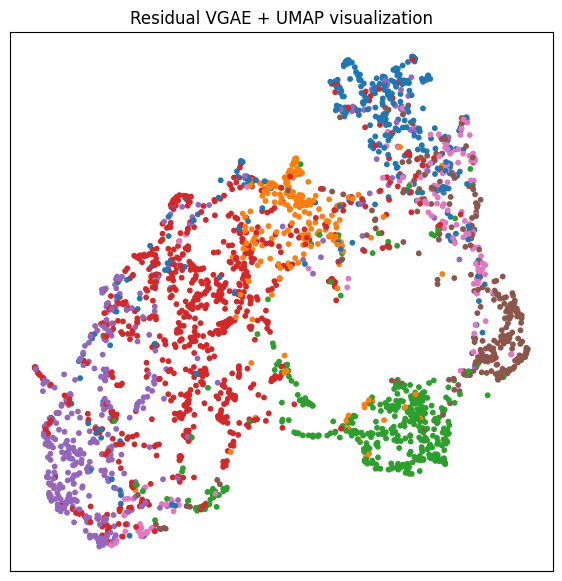

/home/asemerjak/.local/lib/python3.10/site-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 0
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


Performing PaCMAP transformation...


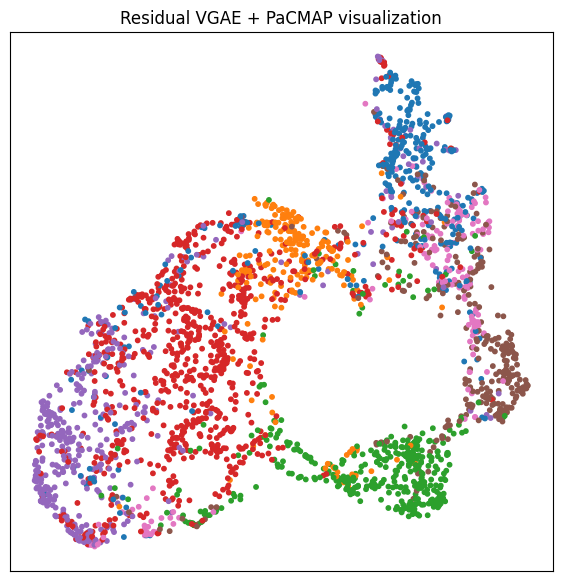

In [5]:
from umap import UMAP
from pacmap import PaCMAP

pure_data = get_fmnist_graph()
pure_X = pure_data.x.cpu().detach().numpy()
pure_labels = pure_data.y.cpu().numpy()

umap = UMAP(n_components=2, random_state=0)

print("Performing UMAP transformation...")

umap_results = umap.fit_transform(encoded_features.cpu().detach().numpy())




fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, umap_results, pure_labels, 'Residual VGAE + UMAP visualization', size=10, sample=False)
plt.show()

pacmap = PaCMAP(n_components=2, random_state=0)

print("Performing PaCMAP transformation...")

pacmap_results = pacmap.fit_transform(encoded_features.cpu().detach().numpy())



fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, pacmap_results, pure_labels, 'Residual VGAE + PaCMAP visualization', size=10, sample=False)
plt.show()